In [1]:
import matplotlib.pyplot as plt
import torch 
import FrEIA.framework as Ff
import torch.distributions as D
from FrEIA.utils import force_to
from functools import partial

In [2]:
from utils import *
from models import *

In [3]:
torch.manual_seed(47)

Settings:

---

In [4]:
device = "cuda:0"
n_layers = 15
res = 500
lim = 1.25
lim_zoom_in = 0.25
lr= 1e-3
batch_size = 128
milestones = [5000,10000,15000]
gamma = 0.1
n_batches = 25000
save_freq = 5000

Initialize the data distribution

---

In [5]:
m1 = torch.tensor([-0.5,-0.5]).reshape(1,-1)
m2 = torch.tensor([0.5,0.5]).reshape(1,-1)
means = torch.cat((m1,m2),0)

S1 = (torch.eye(2) * 0.2).reshape(1,2,2)
S2= (torch.eye(2) * 0.1).reshape(1,2,2)
S = torch.cat((S1,S2),0)
p_GMM = GMM(means = means,covs=S,weights = torch.tensor([0.5,0.5]))

Train the normalizing flow with constant Jacobian determinant

---

In [6]:
INN_const_jac = Ff.SequenceINN(2)

for i in range(n_layers):
    INN_const_jac.append(module_class = ModifiedGINCouplingBlock,subnet_constructor = get_subnet,normalize = True)
INN_const_jac.append(ScalingBlock)

INN_const_jac.to(device)

SequenceINN(
  (module_list): ModuleList(
    (0-14): 15 x ModifiedGINCouplingBlock(
      (subnet1): Sequential(
        (0): Linear(in_features=1, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): ReLU()
        (4): Linear(in_features=128, out_features=128, bias=True)
        (5): ReLU()
        (6): Linear(in_features=128, out_features=2, bias=True)
      )
      (subnet2): Sequential(
        (0): Linear(in_features=1, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): ReLU()
        (4): Linear(in_features=128, out_features=128, bias=True)
        (5): ReLU()
        (6): Linear(in_features=128, out_features=2, bias=True)
      )
    )
    (15): ScalingBlock()
  )
)

In [7]:
train(
    p_data = p_GMM,
    INN = INN_const_jac,
    device = device,
    lr = lr,
    milestones = milestones,
    gamma = gamma,
    batch_size = batch_size,
    n_batches = n_batches,
    experiment_name =  "const_jac_GMM_run-0",
    save_freq = save_freq
    )

100%|██████████| 25000/25000 [17:19<00:00, 24.04it/s]


Train the normalizing flow with variable Jacobian determinant

---

In [8]:
INN_variable_jac = Ff.SequenceINN(2)

for i in range(n_layers):
    INN_variable_jac.append(module_class = ModifiedGINCouplingBlock,subnet_constructor = get_subnet,normalize = False)
  
INN_variable_jac.to(device)

SequenceINN(
  (module_list): ModuleList(
    (0-14): 15 x ModifiedGINCouplingBlock(
      (subnet1): Sequential(
        (0): Linear(in_features=1, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): ReLU()
        (4): Linear(in_features=128, out_features=128, bias=True)
        (5): ReLU()
        (6): Linear(in_features=128, out_features=2, bias=True)
      )
      (subnet2): Sequential(
        (0): Linear(in_features=1, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): ReLU()
        (4): Linear(in_features=128, out_features=128, bias=True)
        (5): ReLU()
        (6): Linear(in_features=128, out_features=2, bias=True)
      )
    )
  )
)

In [9]:
train(
    p_data = p_GMM,
    INN = INN_variable_jac,
    device = device,
    lr = lr,
    milestones = milestones,
    gamma = gamma,
    batch_size = batch_size,
    n_batches = n_batches,
    experiment_name =  "variable_jac_GMM_run-0",
    save_freq = save_freq
    )

100%|██████████| 25000/25000 [16:45<00:00, 24.86it/s]


Load the trained models

---

In [10]:
INN_const_jac.load_state_dict(torch.load(f"./const_jac_GMM_run-0/state-dict_iteration-{n_batches}.pt"))
INN_const_jac.eval()

SequenceINN(
  (module_list): ModuleList(
    (0-14): 15 x ModifiedGINCouplingBlock(
      (subnet1): Sequential(
        (0): Linear(in_features=1, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): ReLU()
        (4): Linear(in_features=128, out_features=128, bias=True)
        (5): ReLU()
        (6): Linear(in_features=128, out_features=2, bias=True)
      )
      (subnet2): Sequential(
        (0): Linear(in_features=1, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): ReLU()
        (4): Linear(in_features=128, out_features=128, bias=True)
        (5): ReLU()
        (6): Linear(in_features=128, out_features=2, bias=True)
      )
    )
    (15): ScalingBlock()
  )
)

In [11]:
INN_variable_jac.load_state_dict(torch.load(f"./variable_jac_GMM_run-0/state-dict_iteration-{n_batches}.pt"))
INN_variable_jac.eval()

SequenceINN(
  (module_list): ModuleList(
    (0-14): 15 x ModifiedGINCouplingBlock(
      (subnet1): Sequential(
        (0): Linear(in_features=1, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): ReLU()
        (4): Linear(in_features=128, out_features=128, bias=True)
        (5): ReLU()
        (6): Linear(in_features=128, out_features=2, bias=True)
      )
      (subnet2): Sequential(
        (0): Linear(in_features=1, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): ReLU()
        (4): Linear(in_features=128, out_features=128, bias=True)
        (5): ReLU()
        (6): Linear(in_features=128, out_features=2, bias=True)
      )
    )
  )
)

Functions to evaluate the densities defined by the normalizing flows

---

In [12]:
#Latent distribution
p_0 = force_to(D.MultivariateNormal(torch.zeros(2),torch.eye(2)),device)

def eval_INN_dist(x,INN,device):
    
    with torch.no_grad():
        #Get the latent representation
        z,jac = INN(x.to(device))

        #Get log prob
        log_prob = p_0.log_prob(z) + jac

        return log_prob.exp()
    

p_const_jac = partial(eval_INN_dist,INN = INN_const_jac,device = device)
p_variable_jac = partial(eval_INN_dist,INN = INN_variable_jac,device = device)

Evaluate the models on a grid

---

In [13]:
#Full range
pdf_target_grid,x_grid,y_grid = eval_pdf_on_grid_2D(pdf = p_GMM,x_lims = [-lim,lim],y_lims = [-lim,lim],x_res = res,y_res = res)
pdf_const_jac_grid,_,_ = eval_pdf_on_grid_2D(pdf = p_const_jac,x_lims = [-lim,lim],y_lims = [-lim,lim],x_res = res,y_res = res)
pdf_variable_jac_grid,_,_ = eval_pdf_on_grid_2D(pdf = p_variable_jac,x_lims = [-lim,lim],y_lims = [-lim,lim],x_res = res,y_res = res)

#Zoom-in 
pdf_target_grid_zoom,x_grid_zoom,y_grid_zoom = eval_pdf_on_grid_2D(pdf = p_GMM,x_lims = [-lim_zoom_in,lim_zoom_in],y_lims = [-lim_zoom_in,lim_zoom_in],x_res = res,y_res = res)
pdf_const_jac_grid_zoom,_,_ = eval_pdf_on_grid_2D(pdf = p_const_jac,x_lims = [-lim_zoom_in,lim_zoom_in],y_lims = [-lim_zoom_in,lim_zoom_in],x_res = res,y_res = res)
pdf_variable_jac_grid_zoom,_,_ = eval_pdf_on_grid_2D(pdf = p_variable_jac,x_lims = [-lim_zoom_in,lim_zoom_in],y_lims = [-lim_zoom_in,lim_zoom_in],x_res = res,y_res = res)

Visualize the densities

---

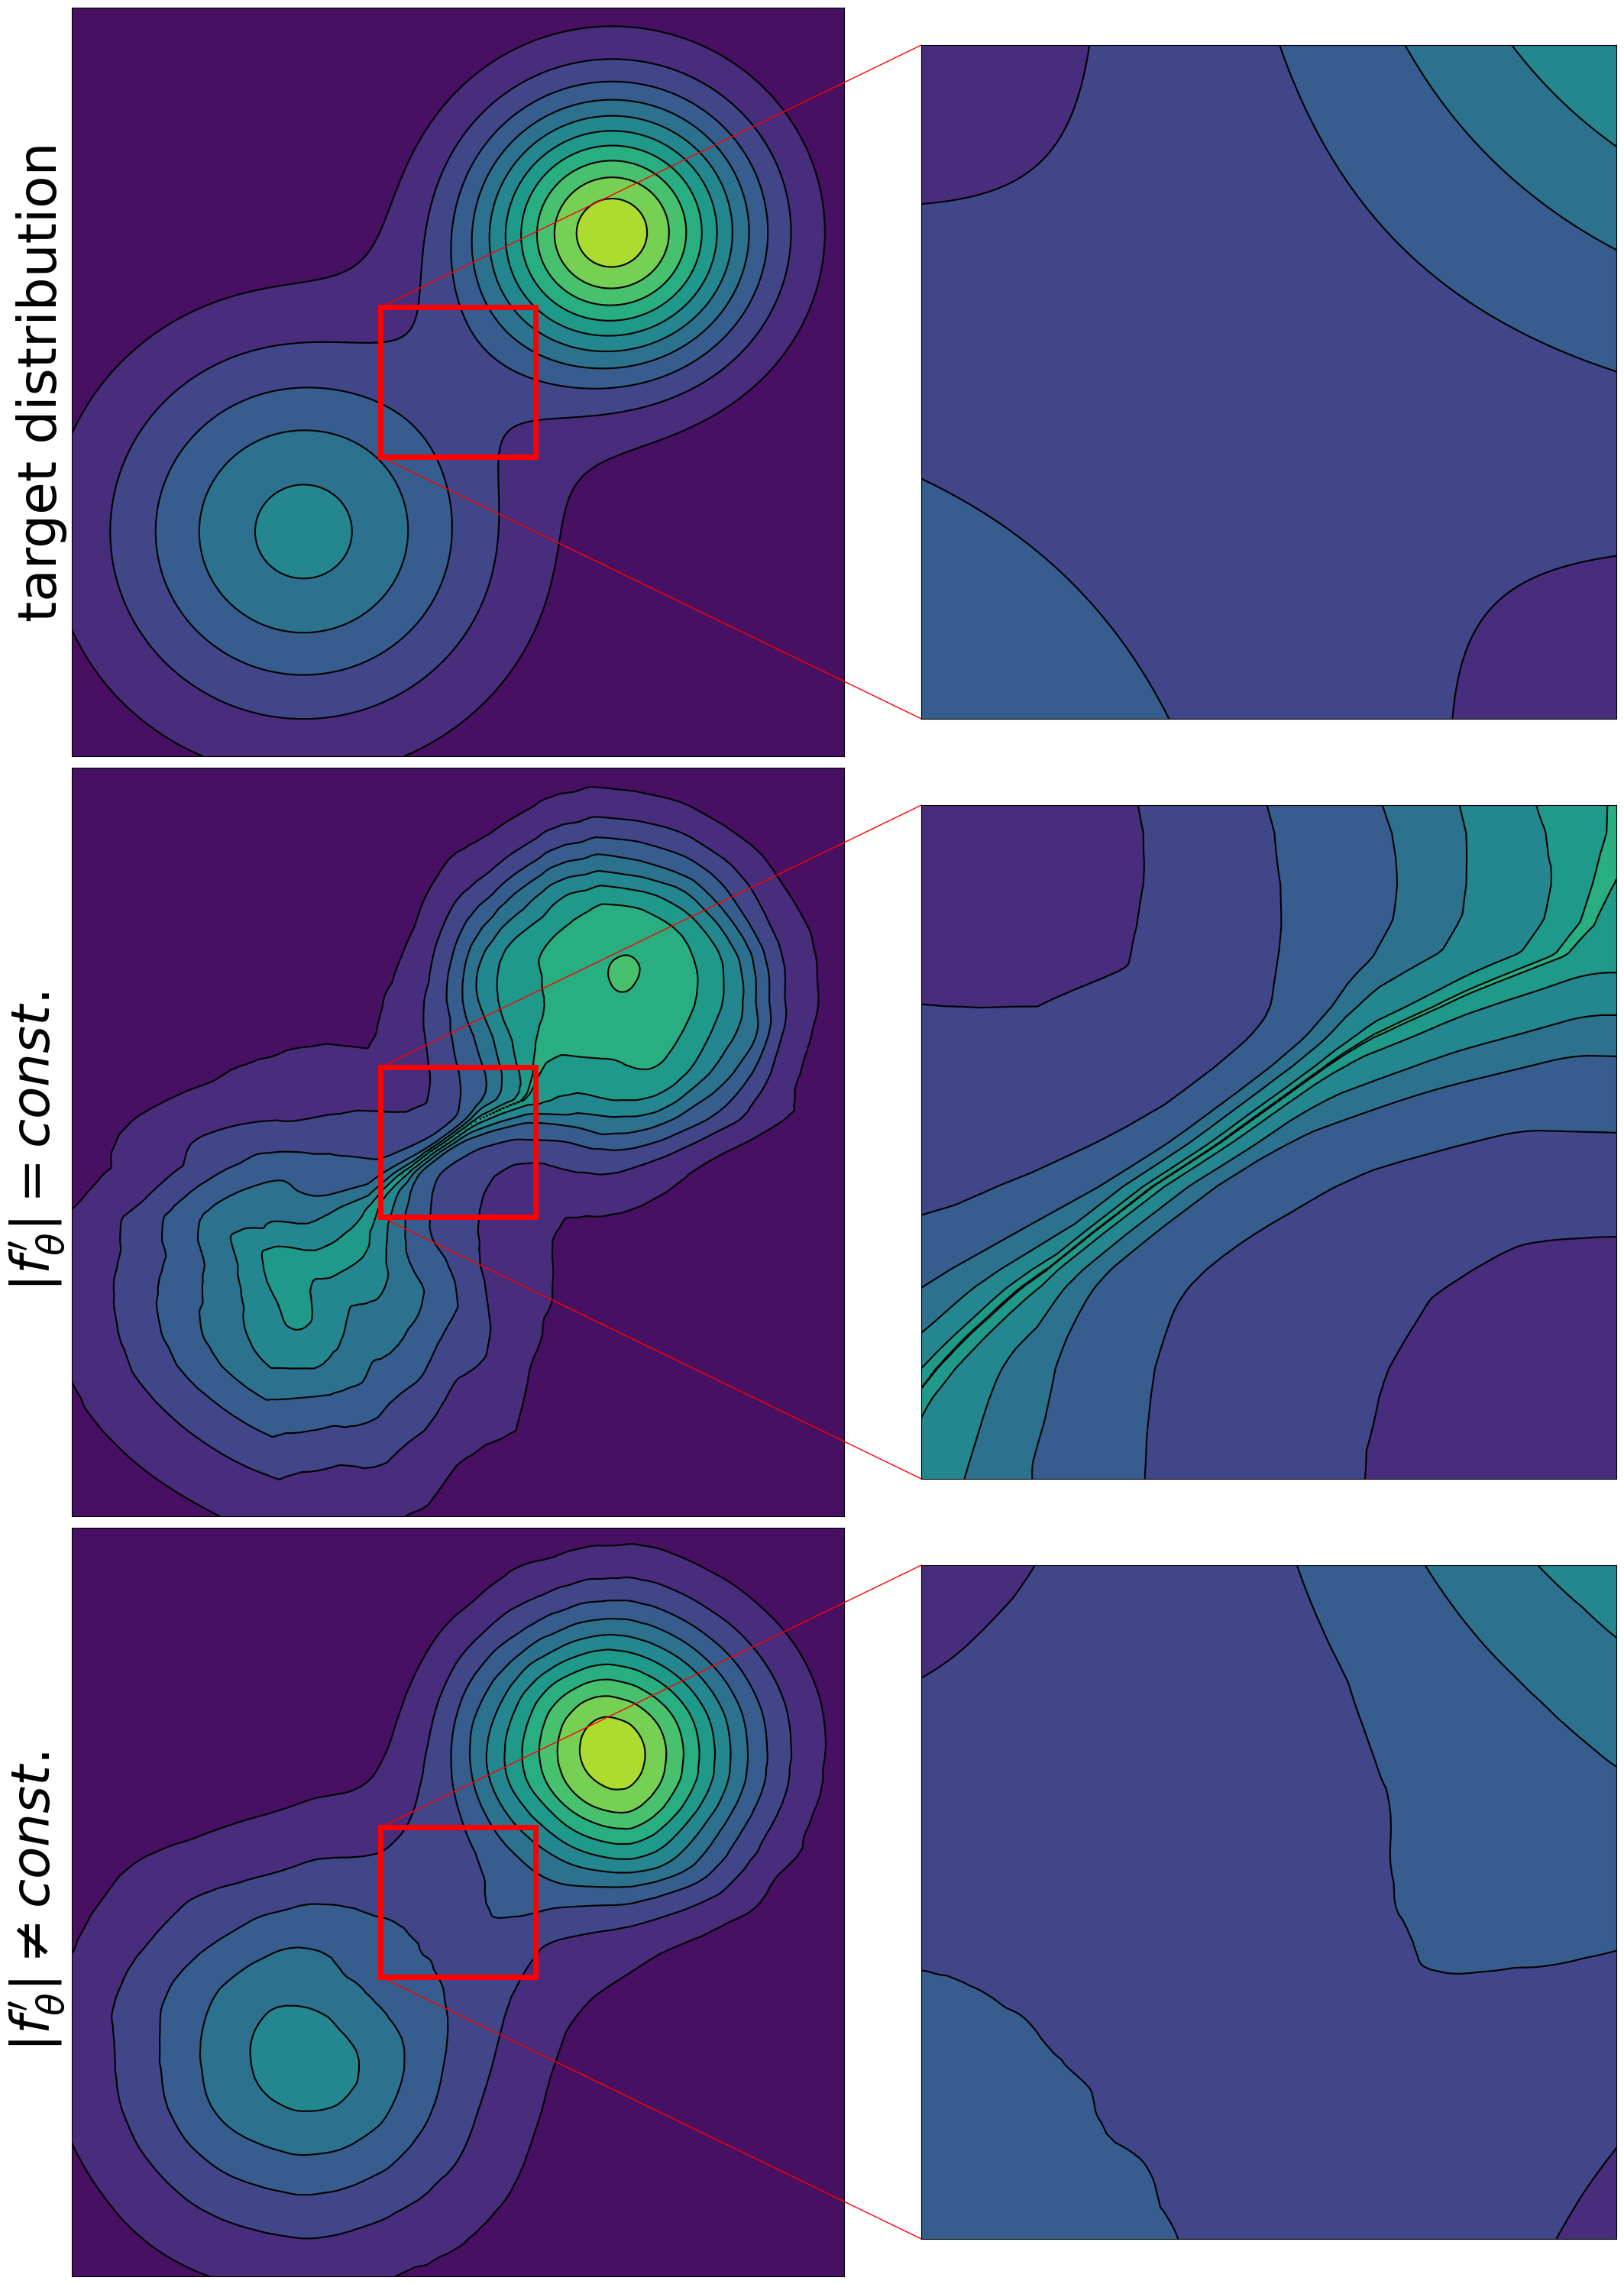

In [14]:
fig,axs = plt.subplots(3,1,figsize = (50,30))


n_levels = 12
eps = 1e-4

#Get the smallest and the highest probability values and copute levels
a = torch.cat((pdf_target_grid.flatten().detach().cpu(),pdf_const_jac_grid.flatten().detach().cpu(),pdf_variable_jac_grid.flatten().detach().cpu()))

v_min = 0
v_max = a.max().item() + 1e-1
dv = (v_max - v_min) / n_levels

levels = np.arange(v_min-eps,v_max+eps,dv)

pdf_zoom_list = [
    pdf_target_grid_zoom,
    pdf_const_jac_grid_zoom.detach().cpu(),
    pdf_variable_jac_grid_zoom.detach().cpu()
]

pdf_list = [
    pdf_target_grid,
    pdf_const_jac_grid.detach().cpu(),
    pdf_variable_jac_grid.detach().cpu()
]

titels = [
    "target distribution",
    r"$|f_{\theta}'| = const.$",
    r"$|f_{\theta}'| \neq const.$",
]

#Plot the levels
for i in range(3):

    #Plot the levels
    axs[i].contourf(x_grid,y_grid,pdf_list[i],levels = levels)
    axs[i].contour(x_grid,y_grid,pdf_list[i],levels = levels,linewidths = 1.5,colors = "k")
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_ylabel(titels[i],fontsize = 50)

    #Zoom-in
    axin = axs[i].inset_axes(
        bounds = [1.1,0.05,0.9,0.9],
        projection = None,
    )


    axin.set_xticks([])
    axin.set_yticks([])
    axin.set_xlim(-lim_zoom_in, lim_zoom_in)
    axin.set_ylim(-lim_zoom_in, lim_zoom_in)
    axs[i].indicate_inset_zoom(axin,linestyle = "-",edgecolor = "r",lw = 5,alpha = 1.0)

    axin.contourf(x_grid_zoom,y_grid_zoom,pdf_zoom_list[i],levels = levels)
    axin.contour(x_grid_zoom,y_grid_zoom,pdf_zoom_list[i],levels = levels,linewidths = 1.5,colors = "k")


plt.tight_layout()

plt.savefig("plot_toy_example_const_jac.pdf")